# Bigram Character-Level Language Model

## Setup

In [2]:
# Imports
import sys
sys.path.append('..') 

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mlflow
import random
from collections import Counter

# Import our data utilities
from src.data_utils import load_dataset

# Set random seeds for reproducibility
random.seed(2147483647)
torch.manual_seed(2147483647)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")

Imports successful!
PyTorch version: 2.5.1
MLflow version: 2.9.2


## Step 1: Load Data

In [3]:
# Load the dataset using our utilities
dataset = load_dataset('../data/processed/names_group3.txt')

# Quick look at the data
print(f"\nFirst 10 training names: {dataset.train_names[:10]}")
print(f"Vocabulary: {dataset.chars}")
print(f"Vocabulary size: {dataset.vocab_size}")

Loaded 102,450 names from names_group3.txt
Vocabulary size: 27 characters
   Characters: abcdefghijklmnopqrstuvwxyz
Dataset splits:
   Train: 81,960 names (80%)
   Val:   10,245 names (10%)
   Test:  10,245 names (10%)

DATASET STATISTICS
Total names:    102,450
Train names:    81,960
Val names:      10,245
Test names:     10,245
Vocabulary:     27 characters
Name length:    min=2, max=15, avg=6.5


First 10 training names: ['makenzie', 'seti', 'topeka', 'mianicole', 'summerlynn', 'basha', 'stevyn', 'wilferd', 'swindell', 'zilla']
Vocabulary: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size: 27


## Step 2: Build Bigram Count Matrix

We'll create a 2D matrix where:
- **Row** = first character in the pair
- **Column** = second character in the pair
- **Value** = how many times this pair appears

Example: `N[0, 5]` = how many times character 0 is followed by character 5

In [4]:
# Create a matrix to store bigram counts
# Size: vocab_size x vocab_size (27x27 in our case)
N = torch.zeros((dataset.vocab_size, dataset.vocab_size), dtype=torch.int32)

print(f"Count matrix shape: {N.shape}")
print(f"This is a {N.shape[0]}x{N.shape[1]} matrix to store all bigram counts")

Count matrix shape: torch.Size([27, 27])
This is a 27x27 matrix to store all bigram counts


### Count all bigrams in the training set

In [5]:
# For each name, count all character pairs
for name in dataset.train_names:
    chars = ['.'] + list(name) + ['.']
    
    # Count each bigram
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = dataset.stoi[ch1] 
        ix2 = dataset.stoi[ch2]  
        N[ix1, ix2] += 1  

print(f"\nCounted {N.sum().item():,} total bigrams from {len(dataset.train_names):,} training names")
print(f"\nExample: Most common bigrams after 'a':")
a_idx = dataset.stoi['a']
for i, count in enumerate(N[a_idx][:10]):
    if count > 0:
        print(f"  'a' → '{dataset.itos[i]}': {count.item():,} times")


Counted 617,080 total bigrams from 81,960 training names

Example: Most common bigrams after 'a':
  'a' → '.': 23,370 times
  'a' → 'a': 1,167 times
  'a' → 'b': 1,212 times
  'a' → 'c': 1,279 times
  'a' → 'd': 2,448 times
  'a' → 'e': 1,783 times
  'a' → 'f': 312 times
  'a' → 'g': 422 times
  'a' → 'h': 5,046 times
  'a' → 'i': 3,408 times


## Step 3: Visualize the Bigram Matrix

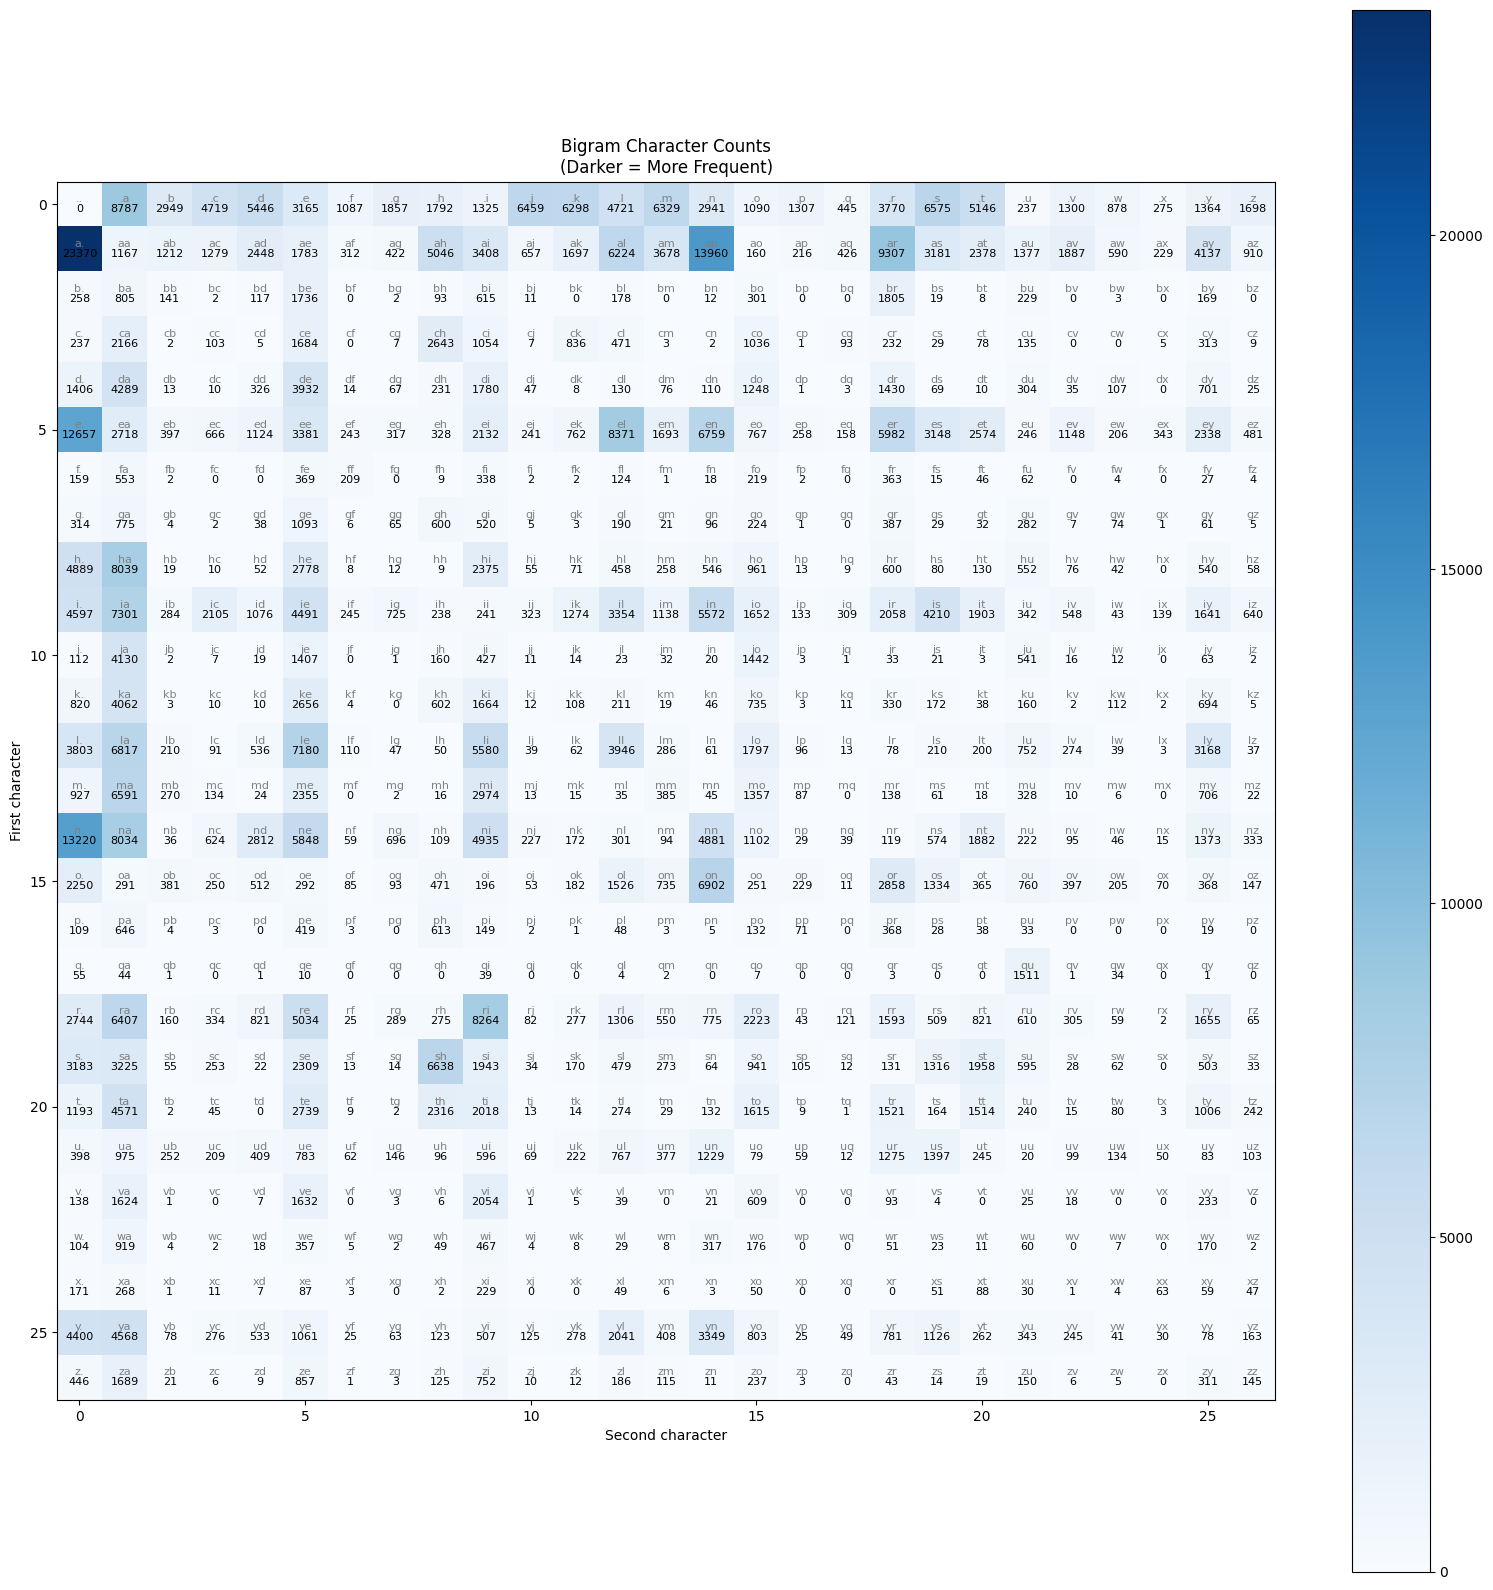

Visualization saved to outputs/bigram_counts.png


In [6]:
# Visualize the bigram counts
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
plt.colorbar()

# Add character labels on axes
for i in range(dataset.vocab_size):
    for j in range(dataset.vocab_size):
        chstr = dataset.itos[i] + dataset.itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray', fontsize=8)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black', fontsize=8)

plt.xlabel('Second character')
plt.ylabel('First character')
plt.title('Bigram Character Counts\n(Darker = More Frequent)')
plt.tight_layout()
plt.savefig('../outputs/bigram_counts.png', dpi=100, bbox_inches='tight')
plt.show()

print("Visualization saved to outputs/bigram_counts.png")

## Step 4: Convert Counts to Probabilities

In [7]:
# Add smoothing (add 1 to all counts to avoid zeros)
P = (N + 1).float()  # Convert to float and add smoothing

# Normalize each row to sum to 1 (convert counts to probabilities)
P = P / P.sum(dim=1, keepdim=True)

print(f"Probability matrix shape: {P.shape}")
print(f"\nExample: Probabilities after 'a':")
a_idx = dataset.stoi['a']
for i in range(10):
    if P[a_idx, i] > 0.01:  
        print(f"  P('{dataset.itos[i]}' | 'a') = {P[a_idx, i]:.3f}")

# Verify each row sums to 1
print(f"\nRow sums (should all be 1.0): {P.sum(dim=1)[:5]}")

Probability matrix shape: torch.Size([27, 27])

Example: Probabilities after 'a':
  P('.' | 'a') = 0.255
  P('a' | 'a') = 0.013
  P('b' | 'a') = 0.013
  P('c' | 'a') = 0.014
  P('d' | 'a') = 0.027
  P('e' | 'a') = 0.019
  P('h' | 'a') = 0.055
  P('i' | 'a') = 0.037

Row sums (should all be 1.0): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


## Step 5: Generate Names

In [8]:
def generate_name(P, stoi, itos, max_length=15):
    """
    Generate a name using the bigram probability matrix.
    
    Args:
        P: Probability matrix (vocab_size x vocab_size)
        stoi: String to index mapping
        itos: Index to string mapping
        max_length: Maximum name length
        
    Returns:
        Generated name as string
    """
    name = []
    ix = stoi['.']  
    
    while True:
        # Sample the next character based on current character's probability distribution
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True).item()
        
        # If we sample the end token, stop
        if ix == stoi['.']:
            break
        
        # Add character to name
        name.append(itos[ix])
        
        # Safety check: don't generate super long names
        if len(name) >= max_length:
            break
    
    return ''.join(name)

# Generate 20 names
print("\nGenerated names using bigram model:\n")
generated_names = []
for i in range(20):
    name = generate_name(P, dataset.stoi, dataset.itos)
    generated_names.append(name)
    print(f"{i+1:2d}. {name}")


Generated names using bigram model:

 1. dexze
 2. lemakuraicazity
 3. ha
 4. vinimittain
 5. llayn
 6. ka
 7. da
 8. staiyauelalerig
 9. miai
10. moliellavo
11. ke
12. teda
13. ka
14. eria
15. sade
16. enkaviyny
17. fobs
18. miglidendorrlas
19. c
20. dshrd


## Step 6: Calculate Loss (Negative Log Likelihood)

In [9]:
def calculate_loss(names, P, stoi):
    """
    Calculate average negative log likelihood on a set of names.
    
    Args:
        names: List of names
        P: Probability matrix
        stoi: String to index mapping
        
    Returns:
        Average negative log likelihood
    """
    log_likelihood = 0.0
    n = 0
    
    for name in names:
        chars = ['.'] + list(name) + ['.']
        for ch1, ch2 in zip(chars, chars[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            prob = P[ix1, ix2]
            log_likelihood += torch.log(prob)
            n += 1
    
    nll = -log_likelihood / n  # Negative log likelihood (average)
    return nll.item()

# Calculate loss on train and validation sets
train_loss = calculate_loss(dataset.train_names, P, dataset.stoi)
val_loss = calculate_loss(dataset.val_names, P, dataset.stoi)

print(f"\nModel Performance:")
print(f"Train Loss (NLL): {train_loss:.4f}")
print(f"Val Loss (NLL):   {val_loss:.4f}")


Model Performance:
Train Loss (NLL): 2.4621
Val Loss (NLL):   2.4647


## Step 7: Neural Network Bigram

In [10]:
# Create training data (all bigrams as input-output pairs)
xs, ys = [], []  

for name in dataset.train_names[:1000]:  
    chars = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = dataset.stoi[ch1]
        ix2 = dataset.stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"Training examples: {len(xs):,}")
print(f"Example: '{dataset.itos[xs[0].item()]}' → '{dataset.itos[ys[0].item()]}'")

Training examples: 7,556
Example: '.' → 'm'


In [11]:
# Initialize the neural network (single weight matrix)
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((dataset.vocab_size, dataset.vocab_size), generator=g, requires_grad=True)

print(f"Weight matrix shape: {W.shape}")
print(f"This is our neural network - just one layer!")

Weight matrix shape: torch.Size([27, 27])
This is our neural network - just one layer!


In [12]:
# Training loop
losses = []

for epoch in range(100):
    # Forward pass
    logits = W[xs] 
    counts = logits.exp() 
    probs = counts / counts.sum(1, keepdim=True)  
    
    # Loss: negative log likelihood
    loss = -probs[torch.arange(len(xs)), ys].log().mean()
    losses.append(loss.item())
    
    # Backward pass
    W.grad = None
    loss.backward()
    
    # Update weights
    W.data -= 50 * W.grad  
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: loss = {loss.item():.4f}")

print(f"\nTraining complete! Final loss: {losses[-1]:.4f}")

Epoch   0: loss = 3.7679
Epoch  10: loss = 2.6729
Epoch  20: loss = 2.5562
Epoch  30: loss = 2.5127
Epoch  40: loss = 2.4901
Epoch  50: loss = 2.4768
Epoch  60: loss = 2.4682
Epoch  70: loss = 2.4622
Epoch  80: loss = 2.4577
Epoch  90: loss = 2.4543

Training complete! Final loss: 2.4518


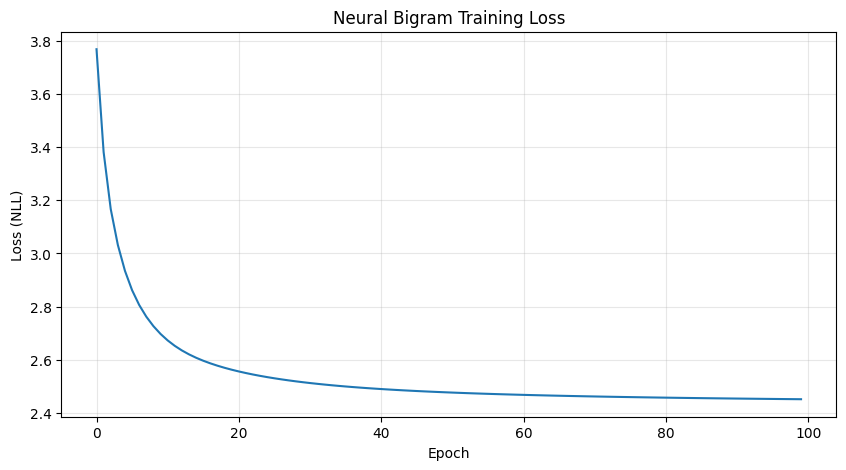

Loss curve saved to outputs/neural_bigram_loss.png


In [13]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (NLL)')
plt.title('Neural Bigram Training Loss')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/neural_bigram_loss.png', dpi=100, bbox_inches='tight')
plt.show()

print("Loss curve saved to outputs/neural_bigram_loss.png")

In [14]:
# Evaluate Neural Bigram on Train and Val Sets
@torch.no_grad()
def eval_neural_bigram(split_names, W):
    """
    Evaluate neural bigram on a dataset split.
    Returns average negative log likelihood.
    """
    loss_sum = 0.0
    n = 0
    
    for name in split_names:
        chars = ['.'] + list(name) + ['.']
        for ch1, ch2 in zip(chars, chars[1:]):
            ix1 = dataset.stoi[ch1]
            ix2 = dataset.stoi[ch2]
            
            # Get logits and compute loss
            logits = W[ix1]
            loss = F.cross_entropy(logits.unsqueeze(0), torch.tensor([ix2]))
            
            loss_sum += loss.item()
            n += 1
    
    return loss_sum / n

# Calculate losses
neural_train_loss = eval_neural_bigram(dataset.train_names, W)
neural_val_loss = eval_neural_bigram(dataset.val_names, W)

print("\nNeural Bigram Performance:")
print(f"  Train Loss: {neural_train_loss:.4f}")
print(f"  Val Loss:   {neural_val_loss:.4f}")
print(f"\n  Compare to counting bigram:")
print(f"    Counting val loss: {val_loss:.4f}")
print(f"    Neural val loss:   {neural_val_loss:.4f}")
print(f"    Difference: {abs(val_loss - neural_val_loss):.4f}")


Neural Bigram Performance:
  Train Loss: 2.5011
  Val Loss:   2.5067

  Compare to counting bigram:
    Counting val loss: 2.4647
    Neural val loss:   2.5067
    Difference: 0.0421


In [15]:
# Generate names with neural network
print("\nGenerated names using neural bigram:\n")

# Convert weights to probabilities
P_neural = F.softmax(W, dim=1)

for i in range(20):
    name = generate_name(P_neural, dataset.stoi, dataset.itos)
    print(f"{i+1:2d}. {name}")


Generated names using neural bigram:

 1. le
 2. jl
 3. penwaisana
 4. r
 5. feniee
 6. zke
 7. deru
 8. firit
 9. kaikajahahbevar
10. h
11. kiysthelecarilm
12. cahh
13. keenan
14. ja
15. kilma
16. avameeromasor
17. lbpejana
18. eeveriseriyenel
19. sillelerdoie
20. meenisammho


## Step 8: Log to MLflow

In [18]:
# Configure MLflow tracking location
import os

# Set tracking URI to your project's mlruns folder
mlflow_tracking_uri = f"file://{os.path.abspath('../mlruns')}"
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [19]:
# Set up MLflow
mlflow.set_experiment("makemore-bigram")

with mlflow.start_run(run_name="counting_bigram"):
    # Log parameters
    mlflow.log_param("model_type", "bigram_counting")
    mlflow.log_param("vocab_size", dataset.vocab_size)
    mlflow.log_param("train_size", len(dataset.train_names))
    mlflow.log_param("smoothing", 1)
    
    # Log metrics
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    
    # Log artifacts
    mlflow.log_artifact("../outputs/bigram_counts.png")
    
    # Save generated names
    with open('../outputs/bigram_generated_names.txt', 'w') as f:
        for name in generated_names:
            f.write(name + '\n')
    mlflow.log_artifact("../outputs/bigram_generated_names.txt")
    
    print("Logged counting bigram to MLflow")

# Log neural bigram separately
with mlflow.start_run(run_name="neural_bigram"):
    mlflow.log_param("model_type", "bigram_neural")
    mlflow.log_param("vocab_size", dataset.vocab_size)
    mlflow.log_param("train_size", 1000) 
    mlflow.log_param("epochs", 100)
    mlflow.log_param("learning_rate", 50)
    
    mlflow.log_metric("final_loss", losses[-1])
    mlflow.log_metric("train_loss", neural_train_loss)
    mlflow.log_metric("val_loss", neural_val_loss)
    
    mlflow.log_artifact("../outputs/neural_bigram_loss.png")
    
    print("Logged neural bigram to MLflow")

print("\nAll done! Check MLflow UI at http://127.0.0.1:5000")

Logged counting bigram to MLflow
Logged neural bigram to MLflow

All done! Check MLflow UI at http://127.0.0.1:5000
